# HR Employee Attrition with Logistic Regression

This notebook explores the "HR Employee Attrition" dataset aiming to answer the following questions:
* How likely is an employee to attrit based on his professional profile?
* What are the most frequent departments, fields, and job roles that experience attrition?
* What are the top five most impactful work attributes that increase the chances of attrition?

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, 
    f1_score, precision_recall_curve, accuracy_score,
)
from sklearn.model_selection import (
    cross_val_predict, cross_val_score, train_test_split,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
import xgboost

sns.set(style="white", font_scale=0.7)

## 1. Get the data

### Collect the data and explore data structure

In [2]:
df = pd.read_csv('../input/hr-analytics-prediction/HR-Employee-Attrition.csv')
df.shape

(1470, 35)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
assert df.notnull().all().all()

### Select numerical and categorical attributes

In [5]:
numerical_attrs = df.select_dtypes(include=np.number).columns.to_list()
categorical_attrs = df.select_dtypes(include='object').columns.to_list()
assert all([col in numerical_attrs + categorical_attrs for col in df.columns])

### Separate a portion of the dataset for the test set
Avoid data snooping by sampling a test set and putting it aside until the testing step.

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=314, stratify=df.Attrition)
print('Shapes:', train_df.shape, test_df.shape)

Shapes: (1176, 35) (294, 35)


## 2. Explore the data

### Visualise attributes

In [7]:
# Start observing the distribution of the target variable – Attrition
train_df.Attrition.value_counts(normalize=True, dropna=False)

No     0.838435
Yes    0.161565
Name: Attrition, dtype: float64

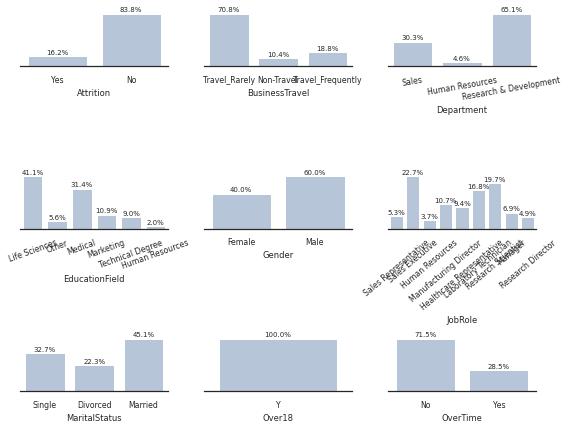

In [8]:
nrows = ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6))

for i, col in enumerate(categorical_attrs):
    row_idx = int(i / nrows)
    col_idx = int(i % ncols)
    sns.countplot(data=train_df, x=col, color='lightsteelblue', ax=axes[row_idx, col_idx])

total = len(train_df)
for rows in axes:
    for ax in rows:
        ax.set_yticklabels([])
        ax.set_ylabel('')
        for p in ax.patches:
            percentage = f'{100 * p.get_height() / total:.1f}%\n'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=7)

axes[0, 2].tick_params(axis='x', rotation=10)
axes[1, 0].tick_params(axis='x', rotation=20)
axes[1, 2].tick_params(axis='x', rotation=40)

sns.despine(left=True, )
plt.tight_layout()

Redundant variables: 
* Over18

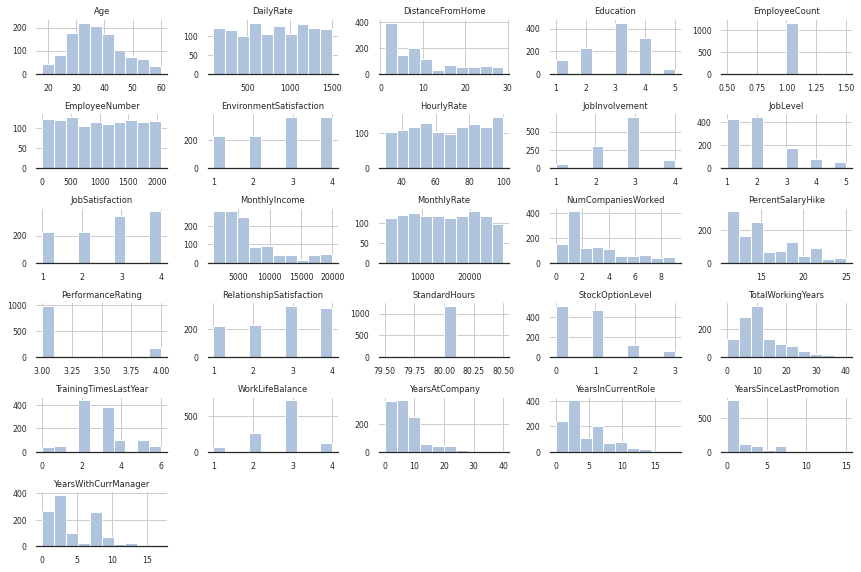

In [9]:
train_df[numerical_attrs].hist(color='lightsteelblue', figsize=(12, 8))
sns.despine(left=True)
plt.tight_layout()

Redundant attributes:
* EmployeeCount
* PerformanceRating
* StandardHours

It looks lke there are a couple of encoded categorical attributes:
* Education: According to the documentation this represents the masked qualification of the employee
* EnvironmentSatisfaction
* JobInvolvement
* JobLevel
* JobSatisfaction
* RelationshipSatisfaction
* WorkLifeBalance

Most of these attributes seem to represent rankings. However, they contain a vague description in the [dataset documentation](https://www.kaggle.com/datasets/rishikeshkonapure/hr-analytics-prediction) at the time of writing and therefore, there exists some uncertainty about what these values represent.

### Study the correlation between attributes

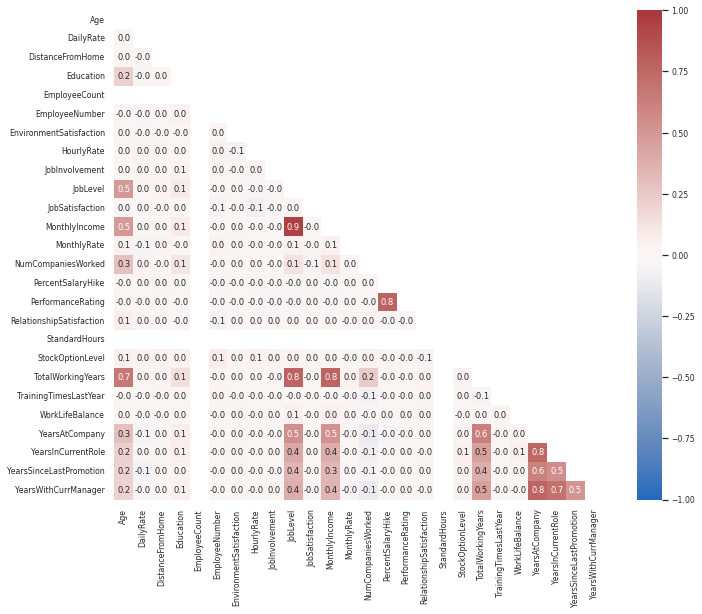

In [10]:
corr_matrix = train_df[numerical_attrs].corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 9))
    ax = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, square=True, annot=True, fmt=".1f", cmap='vlag')

We can also look for correlations with the pandas `scatter_matrix` function. As there are 26 numerical attributes, there would be $26^2=676$ plots. Thus, we are exploring those variables that seem relevant.

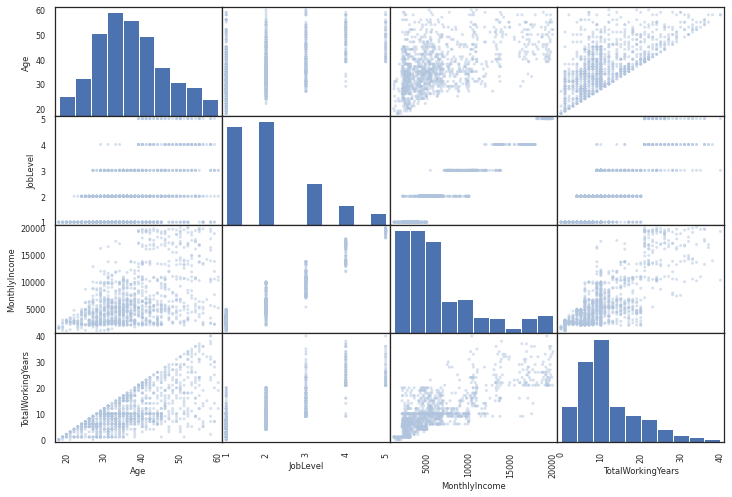

In [11]:
attributes = ['Age', 'JobLevel', 'MonthlyIncome', 'TotalWorkingYears']
scatter_matrix(train_df[attributes], color='lightsteelblue', figsize=(12, 8));

We can observe a couple of things from the scatter matrix above:
- Higher job levels are associated with higher salaries and ages. This potentially indicates that job Level represents the seniority level.
- High salaries tend to go to employees with plenty of work experience.

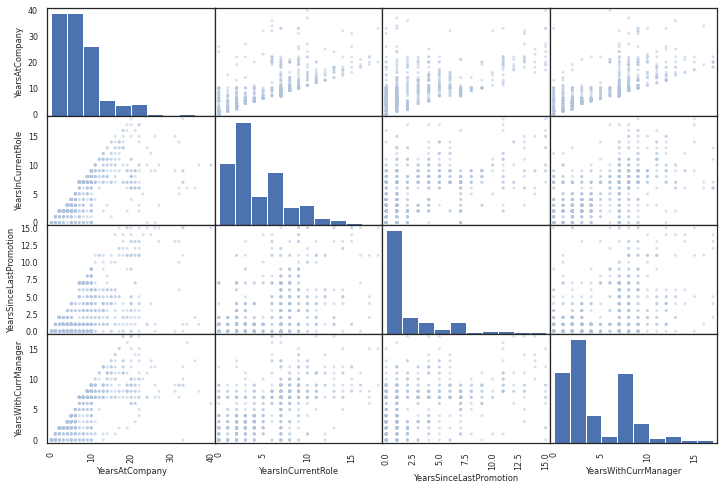

In [12]:
# Analyse highly correlated attributes
attributes = ['YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
scatter_matrix(train_df[attributes], color='lightsteelblue', figsize=(12, 8));

As observed in the correlation matrix, there are highly positive associations between these attributes. We can extract the following observations:
- Relationship between `YearsAtCompany` and `YearsInCurrentRole`: Many people remain in the same role for some time.
- Relationship between `YearsAtCompany` and `YearsWithCurrManager`: There exists a directly proportional tendency with a considerable ceil at 7-8 years with the current manager

## 3. Feature engineering


In [13]:
X_train = train_df.drop(columns='Attrition')
y_train = train_df['Attrition'].copy()

### Feature selection
#### Remove unnecessary attributes

In [14]:
removed_attrs = set(['Over18', 'Gender', 'EmployeeCount', 'PerformanceRating', 'StandardHours', 'Attrition'])

categorical_attrs = list(set(categorical_attrs) - removed_attrs)
numerical_attrs = list(set(numerical_attrs) - removed_attrs)

assert len(categorical_attrs) == 6
assert len(numerical_attrs) == 23

X_train = X_train[categorical_attrs+numerical_attrs].copy()
X_train.shape

(1176, 29)

It is worth noting that gender is removed since the overrepresentation of males in the dataset might introduce sex bias in the results.

### Feature transformation

In [15]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

assert y_train.sum() == train_df[train_df.Attrition=='Yes'].shape[0]

In [16]:
transformation_pipeline = ColumnTransformer([
    ('num', StandardScaler(), numerical_attrs),
    ('cat', OneHotEncoder(), categorical_attrs),
], remainder='drop')
X_train = transformation_pipeline.fit_transform(X_train)

In [17]:
# Observe the transformed data
feature_names = np.array([])
for transf in transformation_pipeline.transformers_:
        feature_names = np.append(feature_names, transf[1].get_feature_names_out())

pd.DataFrame(X_train, columns=feature_names)

,NumCompaniesWorked,JobSatisfaction,JobInvolvement,MonthlyIncome,YearsWithCurrManager,DistanceFromHome,EmployeeNumber,PercentSalaryHike,YearsAtCompany,WorkLifeBalance,...,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,-0.687371,-0.672870,1.785137,-0.820616,-1.162139,0.323020,-0.882268,-0.072138,-0.989759,0.326855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.687371,1.135805,0.369546,-0.245320,-0.600876,0.811915,1.083135,2.655645,-0.162380,0.326855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.087940,0.231467,0.369546,-0.032946,2.486071,-1.021441,0.021784,-0.890473,1.823329,0.326855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.687371,-1.577208,-1.046045,0.323035,1.363545,0.934139,0.649322,-0.617694,0.499523,-1.091526,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.286802,1.135805,-2.461636,-0.088480,-0.600876,-0.899218,-0.792856,1.291754,-0.327856,0.326855,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,-0.286802,0.231467,-2.461636,-0.181976,-0.600876,-1.021441,-1.001484,-0.617694,-0.327856,0.326855,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1172,0.514336,1.135805,0.369546,2.823145,-0.881507,-0.776994,-0.589196,-0.890473,-0.824283,1.745235,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1173,-0.687371,1.135805,-1.046045,-0.005396,1.924808,-1.021441,0.280085,-0.617694,1.161426,-1.091526,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1174,1.716042,0.231467,1.785137,-0.646856,-0.600876,-0.165875,1.026838,0.473419,-0.658807,0.326855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 4. Modelling

In [18]:
def display_results(y_train, y_train_pred):
    """
    Prints the confusion matrix along with performance scores

    Parameters
    ---
    y_train: 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    
    y_train_pred: 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.


    Returns
    ---
    None
    """
    print('Confusion matrix\n', confusion_matrix(y_train, y_train_pred))
    print('Accuracy:', accuracy_score(y_train, y_train_pred))
    print('Precision:', precision_score(y_train, y_train_pred))
    print('Recall:', recall_score(y_train, y_train_pred))
    print('F1-score:', f1_score(y_train, y_train_pred))

In [19]:
log_reg = LogisticRegression()
y_train_pred = cross_val_predict(log_reg, X_train, y_train, cv=10)
display_results(y_train, y_train_pred)

Confusion matrix
 [[957  29]
 [106  84]]
Accuracy: 0.8852040816326531
Precision: 0.7433628318584071
Recall: 0.4421052631578947
F1-score: 0.5544554455445544


Compare the results of Logistic Regression with other techniques using the standard parameters:

In [20]:
rf = RandomForestClassifier(random_state=314)
y_train_pred = cross_val_predict(rf, X_train, y_train, cv=10)
display_results(y_train, y_train_pred)

Confusion matrix
 [[975  11]
 [155  35]]
Accuracy: 0.858843537414966
Precision: 0.7608695652173914
Recall: 0.18421052631578946
F1-score: 0.2966101694915254


In [21]:
svc = SVC(random_state=314)
y_train_pred = cross_val_predict(svc, X_train, y_train, cv=10)
display_results(y_train, y_train_pred)

Confusion matrix
 [[982   4]
 [152  38]]
Accuracy: 0.8673469387755102
Precision: 0.9047619047619048
Recall: 0.2
F1-score: 0.32758620689655177


In [22]:
xgb = xgboost.XGBClassifier(objective='binary:logistic')
y_train_pred = cross_val_predict(xgb, X_train, y_train, cv=10)
display_results(y_train, y_train_pred)

Confusion matrix
 [[958  28]
 [135  55]]
Accuracy: 0.8613945578231292
Precision: 0.6626506024096386
Recall: 0.2894736842105263
F1-score: 0.40293040293040294


Considering standard parameters, Logistic regression is the model with the highest *accuracy* and *f1-score*.

## 5. Fine-tune the model

In [23]:
param_grid = [
    {'C': np.arange(0.3, 1., 0.1), 'class_weight': [None, 'balanced']}
]
grid_search_log_reg = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='f1', verbose=1)
grid_search_log_reg.fit(X_train, y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'class_weight': [None, 'balanced']}],
             scoring='f1', verbose=1)

In [24]:
grid_search_log_reg.best_params_

{'C': 0.4, 'class_weight': None}

In [25]:
y_train_pred = cross_val_predict(grid_search_log_reg.best_estimator_, X_train, y_train, cv=10)
display_results(y_train, y_train_pred)

Confusion matrix
 [[960  26]
 [105  85]]
Accuracy: 0.8886054421768708
Precision: 0.7657657657657657
Recall: 0.4473684210526316
F1-score: 0.5647840531561462


**Note**: Another step could involve lowering the decision threshold to increase the recall value at the cost of reducing the precision.

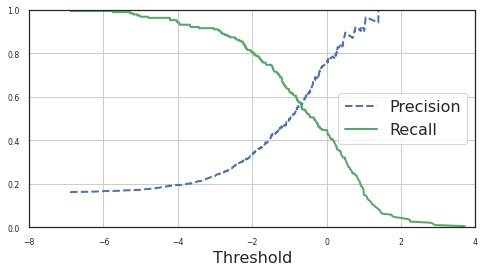

In [26]:
# Visualise the decision function
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Visualise the precision and recal curves

    Parameters
    ---
    precisions : ndarray of shape (n_thresholds + 1,)
        Precision values such that element i is the precision of
        predictions with score >= thresholds[i] and the last element is 1.

    recalls : ndarray of shape (n_thresholds + 1,)
        Decreasing recall values such that element i is the recall of
        predictions with score >= thresholds[i] and the last element is 0.

    thresholdss : ndarray of shape (n_thresholds,)
        Increasing thresholds on the decision function used to compute
        precision and recall where `n_thresholds = len(np.unique(probas_pred))`.

    Returns
    ---
    None
    """
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-8, 4, 0, 1])


y_train_scores = cross_val_predict(grid_search_log_reg.best_estimator_, X_train, y_train, cv=10, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_scores)

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### Model coefficients

In [27]:
sorted(zip(grid_search_log_reg.best_estimator_.coef_[0], feature_names), reverse=True)

[(0.9053234697196524, 'OverTime_Yes'),
 (0.7184327122309394, 'BusinessTravel_Travel_Frequently'),
 (0.6310880048900147, 'EducationField_Technical Degree'),
 (0.6309093082522192, 'JobRole_Laboratory Technician'),
 (0.5948756266697719, 'JobRole_Sales Representative'),
 (0.5929525583330953, 'MaritalStatus_Single'),
 (0.4800675617681465, 'YearsSinceLastPromotion'),
 (0.4609116455440353, 'NumCompaniesWorked'),
 (0.3774861135256909, 'YearsAtCompany'),
 (0.3674734557374266, 'DistanceFromHome'),
 (0.3386320375552617, 'Department_Sales'),
 (0.28562237627583625, 'EducationField_Human Resources'),
 (0.21507849673425264, 'JobRole_Human Resources'),
 (0.05112634625198613, 'HourlyRate'),
 (0.04187286250564513, 'JobRole_Manager'),
 (-0.00154579666898368, 'PercentSalaryHike'),
 (-0.014109781493419583, 'BusinessTravel_Travel_Rarely'),
 (-0.020531759312294565, 'Department_Human Resources'),
 (-0.026427217460478075, 'Education'),
 (-0.026613098030528047, 'EmployeeNumber'),
 (-0.04093497489156173, 'Educat

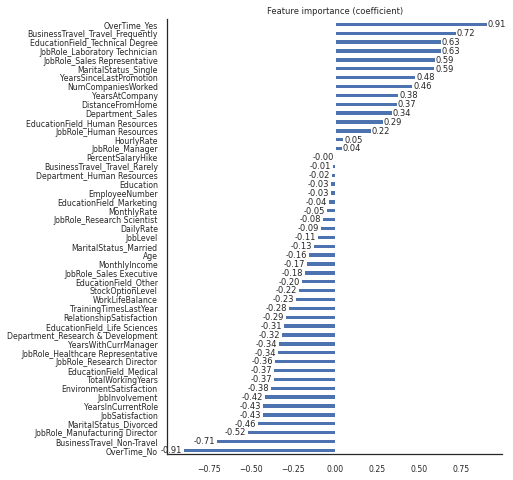

In [28]:
sns.set_style('white')
ax = pd.DataFrame(
    {'coef': grid_search_log_reg.best_estimator_.coef_[0]}, 
    index=feature_names
).sort_values(by='coef').plot(kind='barh', figsize=(6, 8), title='Feature importance (coefficient)')
ax.bar_label(ax.containers[0], fmt='%.2f', padding=1)
ax.get_legend().remove()
sns.despine()

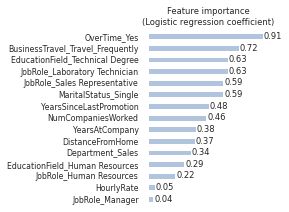

In [29]:
ax = pd.DataFrame(
    {'coef': grid_search_log_reg.best_estimator_.coef_[0]}, 
    index=feature_names
).sort_values(by='coef').iloc[-15:].plot(kind='barh', color='lightsteelblue', figsize=(4, 3), title='Feature importance\n(Logistic regression coefficient)')
ax.bar_label(ax.containers[0], fmt='%.2f', padding=1)
ax.get_legend().remove()
ax.set_xticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

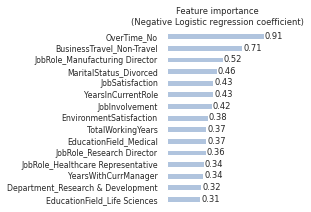

In [30]:
ax = pd.DataFrame(
    {'coef': grid_search_log_reg.best_estimator_.coef_[0]}, 
    index=feature_names
).sort_values(by='coef', ascending=False).abs().iloc[-15:].plot(
    kind='barh', color='lightsteelblue', figsize=(4, 3), title='Feature importance\n(Negative Logistic regression coefficient)'
)
ax.bar_label(ax.containers[0], fmt='%.2f', padding=1)
ax.get_legend().remove()
ax.set_xticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

### Model evaluation on the test set

In [31]:
final_model = grid_search_log_reg.best_estimator_

X_test = test_df.drop(columns='Attrition')
y_test = test_df['Attrition'].copy()

X_test = transformation_pipeline.transform(X_test)
y_test = encoder.transform(y_test)

y_test_pred = final_model.predict(X_test)
display_results(y_test, y_test_pred)

Confusion matrix
 [[241   6]
 [ 28  19]]
Accuracy: 0.8843537414965986
Precision: 0.76
Recall: 0.40425531914893614
F1-score: 0.5277777777777778


## 6. Answer the main questions

### How likely is an employee to attrit based on his professional profile?

In [32]:
np.where(y_test==1)

(array([  3,  12,  22,  25,  33,  37,  48,  49,  56,  65,  70,  78,  80,
         97, 100, 118, 125, 128, 130, 134, 140, 146, 163, 169, 172, 174,
        181, 187, 189, 190, 192, 199, 206, 211, 213, 214, 215, 220, 223,
        244, 247, 256, 263, 270, 281, 285, 286]),)

Let's analyse the case for a single full-time research scientist with a background on Life Sciences who travels frequently, works more than the standard hours, and has barely any engagement with the company:

In [33]:
print(f'The employee has %{final_model.predict_proba([X_test[286]])[0, 1]*100:.1f} chances of attrition.')
test_df.iloc[286]

The employee has %80.1 chances of attrition.


Age                                             29
Attrition                                      Yes
BusinessTravel                   Travel_Frequently
DailyRate                                      459
Department                  Research & Development
DistanceFromHome                                24
Education                                        2
EducationField                       Life Sciences
EmployeeCount                                    1
EmployeeNumber                                1868
EnvironmentSatisfaction                          4
Gender                                        Male
HourlyRate                                      73
JobInvolvement                                   2
JobLevel                                         1
JobRole                         Research Scientist
JobSatisfaction                                  4
MaritalStatus                               Single
MonthlyIncome                                 2439
MonthlyRate                    

In [34]:
print(f'The employee has %{final_model.predict_proba([X_test[0]])[0, 1]*100:.1f} chances of attrition.')
test_df.iloc[0], final_model.predict_proba([X_test[0]])[0, 1]

The employee has %10.5 chances of attrition.


(Age                                             41
 Attrition                                       No
 BusinessTravel                       Travel_Rarely
 DailyRate                                     1283
 Department                  Research & Development
 DistanceFromHome                                 5
 Education                                        5
 EducationField                             Medical
 EmployeeCount                                    1
 EmployeeNumber                                1448
 EnvironmentSatisfaction                          2
 Gender                                        Male
 HourlyRate                                      90
 JobInvolvement                                   4
 JobLevel                                         1
 JobRole                         Research Scientist
 JobSatisfaction                                  3
 MaritalStatus                              Married
 MonthlyIncome                                 2127
 MonthlyRate

### What are the top five most impactful work attributes that increase the changes of attrition?

According to the feature importance presented above, the most impactful attributes that increase attrition are:
- work overtime
- travel frequently
- technical and sales roles
- being single
- lack of job promotion

### What are the most frequent departments, fields, and job roles that experience attrition?

In [35]:
mean_attritions = lambda x: (x == 'Yes').mean()

In [36]:
attrition_by_dpt = train_df.groupby(by='Department').agg({'Attrition': mean_attritions}).sort_values(by='Attrition', ascending=False)
attrition_by_dpt

,Attrition
Department,
Sales,0.207865
Human Resources,0.166667
Research & Development,0.139687


In [37]:
attrition_by_edu = train_df.groupby(by='EducationField').agg({'Attrition': mean_attritions}).sort_values(by='Attrition', ascending=False)
attrition_by_edu

,Attrition
EducationField,
Technical Degree,0.273585
Human Resources,0.250000
Marketing,0.210938
Medical,0.140921
Life Sciences,0.140787
Other,0.121212


In [38]:
attrition_by_job = train_df.groupby(by='JobRole').agg({'Attrition': mean_attritions}).sort_values(by='Attrition', ascending=False)
attrition_by_job

,Attrition
JobRole,
Sales Representative,0.403226
Laboratory Technician,0.243655
Human Resources,0.209302
Sales Executive,0.176030
Research Scientist,0.168103
Healthcare Representative,0.072727
Manager,0.061728
Manufacturing Director,0.055556
Research Director,0.034483


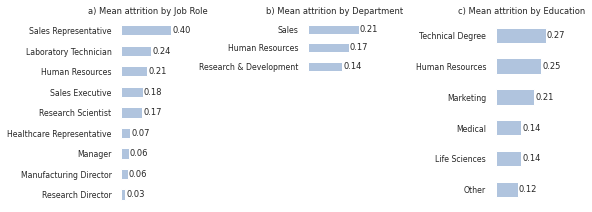

In [39]:
def plot_table(df, title='', ax=None):
    """
    Plot the dataframe using horizontal bar figure

    Parameters
    ---
    df : Pandas DataFrame containing one target column

    title : str with the figure title

    ax : matplotlib axis to put the plot

    Returns
    ---
    None
    """
    ax = df.sort_values(by='Attrition', ascending=True).plot(kind='barh', color='lightsteelblue', ax=ax, title=title)
    ax.bar_label(ax.containers[0], fmt='%.2f', padding=1)
    ax.get_legend().remove()
    ax.set_xticks([])
    ax.set_ylabel('')
    sns.despine(left=True, bottom=True)
    plt.tight_layout()


fig = plt.figure(figsize=(8, 3))
spec = fig.add_gridspec(ncols=3, nrows=3)

ax0 = fig.add_subplot(spec[0:3, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[0:3, 2])

plot_table(attrition_by_job, title='a) Mean attrition by Job Role', ax=ax0)
plot_table(attrition_by_dpt, title='b) Mean attrition by Department', ax=ax1)
plot_table(attrition_by_edu, title='c) Mean attrition by Education', ax=ax2)